In [32]:
# IMPORTS

import os
from typing import List, Tuple
import numpy as np
import matplotlib.pylab as plt
import blimpy as bl
from astropy.time import Time
#import qrcode
#import moviepy.video.io.ImageSequenceClip
%matplotlib inline

In [3]:
# CONSTANTS

MAX_IMSHOW_POINTS = (8192, 4096 / 8)
TELESCOPE = 'GBT'
OBS_TIME = '300s x 3'
COLUMN = 52

BAD_FREQS = [[0, 1100], [1200, 1340], [1900, 2000]]

grid = plt.GridSpec(12, 8, wspace=1.2, hspace=0.1)

In [3]:
# FUNCTIONS

In [4]:
# The following two functions are modified versions taken from https://www.kaggle.com/tentotheminus9/l-band-2017
# Credit: Rob Harrand

def plot_waterfall(fil, f_start=None, f_stop=None, if_id=0, 
                   logged=True, cb=False, freq_label=False, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """


    plt.rc('font', size=12)

    plot_f, plot_data = fil.grab_data(f_start, f_stop, if_id)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]

    #print(dec_fac_x)
        
    plot_data = bl.utils.rebin(plot_data, int(dec_fac_x), int(dec_fac_y))
    
    plot_data = np.fliplr(plot_data)
    plot_f = np.flipud(plot_f)

    if MJD_time:
        extent=(plot_f[0], plot_f[-1], fil.timestamps[-1], fil.timestamps[0])
    else:
        extent=(plot_f[0], plot_f[-1], (fil.timestamps[-1]-fil.timestamps[0])*24.*60.*60, 0.0)

    this_plot = plt.imshow(plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
        cmap='hot',
        **kwargs
    )
    if cb:
        plt.colorbar()

    if freq_label:
        plt.xlabel("Frequency (Hz)", size=12)
    if MJD_time:
        plt.ylabel("Time (MJD)", size=12)
    else:
        plt.ylabel("Time (s)", size=12)


#     print('this is plot_data:', plot_data)
#     print('this is plot_data\'s shape:', plot_data.shape)
#     print('this is plot_f:', plot_f)
#     print('this is plot_f\'s shape', plot_f.shape)
    
    return this_plot

def make_waterfall_plots(filenames_list, target, f_start, f_stop, ion=False, correction_in=0, 
                         line1=None, line2=None, **kwargs):
    ''' Makes waterfall plots per group of ON-OFF pairs (up to 6 plots.)
    '''

    plt.rc('font', size=12)

    if ion:
        plt.ion()

#    n_plots = len(filenames_list)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True)
#    fig = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(10, 2*n_plots))
#    fig = plt.subplots(1, 2, 1, sharex=True, sharey=True)

    fil = bl.Waterfall(filenames_list[0], f_start=f_start, f_stop=f_stop)
    
    A1_avg = np.median(fil.data)
    A1_max = fil.data.max()
    A1_std = np.std(fil.data)

    labeling = ['A','B','A','C','A','D']

    delta_f = np.abs(f_start-f_stop)
    mid_f = np.abs(f_start+f_stop)/2.
    
    #Adjust the incorrect header data
    correction = mid_f - correction_in
    mid_f_text = mid_f - correction

    for i,filename in enumerate(filenames_list):
        plt.subplot(grid[i + 6, :])

        fil = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop)

        this_plot = plot_waterfall(fil,f_start=f_start, f_stop=f_stop,
                                   vmin=A1_avg-A1_std*0,vmax=A1_avg+5.*A1_std,**kwargs)
        
        if line1 != None:
            plt.axvline(x=line1, color = 'white', ls='--')
        if line2 != None:
            plt.axvline(x=line2, color = 'white', ls='--')

        if i == 0:
            plt.title('Waterfall plot', size=13.5)

        if i < len(filenames_list)-1:
            plt.xticks(np.arange(f_start, f_stop, delta_f/4.), ['','','',''])

    #Some plot formatting.
    ax = plt.gca()
    #ax.invert_xaxis()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    if target == 'HIP7981':
        #f_start -= 0.3
        #f_stop  += 0.3
        factor = 1e3
        units = 'kHz'
    else:
        factor = 1e6
        units = 'Hz'
    
    plt.xticks(np.arange(f_start, f_stop + 0.1 * delta_f/4, delta_f/4),
               [round(loc_freq) for loc_freq in np.arange(
                   (f_start-mid_f), (f_stop+0.1*delta_f/4-mid_f), delta_f/4)*factor])
    plt.xlabel("Relative frequency in %s from %f MHz"%(units, mid_f), size=12)
    

    #to plot color bar. for now.
#     fig = plt.subplots(6, sharex=True, sharey=True)
#     cax = fig[0].add_axes([0.9, 0.12, 0.03, 0.75])
#     fig[0].colorbar(this_plot,cax=cax,label='Power (Arbitrary Units)')

    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
#    plt.subplots_adjust(hspace=0,wspace=0)

In [5]:
def get_cadence_list(dirname: str) -> List[str]:
    """Return the list of cadences studied by the ML algorithm whose results are in the directory dirname.
    """

    cadence_list = []
    
    filenames = os.listdir(dirname)
    
    # There are three types of .csv files in the results directory:
        # [cadence_name].csv list the hit candidates in a cadence
        # [cadence_name]_directory.csv locate the h5 files in the Berkeley machine
        # [cadence_name]_stats_0.csv displays some info on the ML performance

    # To obtain [cadence_name]:
    for filename in filenames:
        if not filename.startswith('.'):
            if 'directory' not in filename and 'stats' not in filename:
                cadence_list.append(filename[:-4])
    
    return cadence_list

In [6]:
# Helper function

def get_cadence_h5files(cadence_name: str, dirname: str) -> List[str]:
    """Return the paths to the h5 files that make up cadence_name from the results directory dirname.
    """
    
    h5files = []
    
    # Add a forward slash for dirname if not included in the argument
    if dirname[-1] != '/':
        dirname += '/'
    
    filename = dirname + cadence_name + '_directory.csv'
        
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        h5file = info[1][20:]
        h5files.append(h5file)
    
    return h5files

In [7]:
# Helper function

def is_in_rfi_bin(mid_freq: float, rfi_bins: List[List[float]]) -> bool:
    """Return True if and only if mid_freq is a frequency contained in one of the intervals listed in rfi_bins.
    """
    
    in_rfi = False
    
    for interval in rfi_bins:
        if interval[0] <= mid_freq < interval[1]:
            in_rfi = True
    
    return in_rfi

In [8]:
# Helper function

def get_hits(cadence_name: str, dirname: str) -> List[List[float]]:
    """Return a list of sublists where each sublist is the start frequency, the end frequency, and the confidence
    of a hit candidate for cadence_name from the results directory dirname.
    """
    
    hits = []
    
    # Add a forward slash for dirname if not included in the argument
    if dirname[-1] != '/':
        dirname += '/'

    filename = dirname + cadence_name + '.csv'
 
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    for line in lines[1:]:
        info = line.strip().split(',')
        start = float(info[1])
        stop = float(info[2])
        fit = float(info[3])
        
        mid = (start + stop) / 2
        if not is_in_rfi_bin(mid, BAD_FREQS):
            hits.append([start, stop, fit])

    return hits

In [9]:
class Cadence:
    
    
    def __init__(self, cadence_name: str, dirname: str) -> None:
        
        target = cadence_name.split('-')[0]
        
        self.name = cadence_name
        self.target = target
        self.h5files = get_cadence_h5files(cadence_name, dirname)
        self.hits = get_hits(cadence_name, dirname)
        self.num_hits = len(self.hits)
    
    def __str__(self) -> str:
        
        if self.num_hits == 1:
            return 'Cadence {} with {} hit'.format(self.name, self.num_hits)
        
        return 'Cadence {} with {} hits'.format(self.name, self.num_hits)
    
    
    def get_cadence_type(self) -> str:
        """Return 'ABABAB', 'ABACAD', or 'other' depending on the cadence type. 'ABABAB' type does not 
        differentiate between cases where OFF-source is its own potential target or not.
        """        
        
        if len(self.h5files) == 6:
        
            lst = []

            for i in range(len(self.h5files)):
                fb = bl.Waterfall(self.h5files[i], load_data=False)
                source = fb.header['source_name']
                lst.append(source)

            # Check for A = A = A in ABABAB and ABACAD
            if lst[0] == lst[2] == lst[4]:
                
                # Check for B = B = B and A != B in ABABAB
                if lst[1] == lst[3] == lst[5] \
                and lst[0] != lst[1]:
                    return 'ABABAB'
                          
                # Check for B != C != D != B (non of which are A) in ABACAD
                elif lst[1] != lst[3] and lst[1] != lst[5] and lst[3] != lst[5] \
                and lst[0] != lst[1] and lst[0] != lst[3] and lst[0] != lst[5]:
                    return 'ABACAD'
        
        return 'other'
    
    
    def get_RA(self) -> str:
        """Return the right ascension of the primary target.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        RA = fb.header['src_raj']
        
        return str(RA)
    
    
    def get_DEC(self) -> str:
        """Return the declination of the primary target.
        """
            
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        DEC = fb.header['src_dej']
        
        return str(DEC)
    
    
    def get_date_time(self, ISOT=True) -> str:
        """Return the date and time at the start of the cadence. If ISOT is True, date format is ISO time. 
        Otherwise, date format is mean Julian day.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        mjd = fb.header['tstart']
        
        if ISOT:
            return Time(mjd, format='mjd').isot
        
        return str(mjd)
    
    
    def get_min_freq(self) -> str:
        """Return the minimum frequency observed in the cadence.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        
        if fb.header['foff'] < 0:
            min_freq = fb.container.f_start - fb.header['foff']
        else:
            min_freq = fb.container.f_start
        
        return str(min_freq) + ' MHz'
    

    def get_max_freq(self) -> str:
        """Return the maximum frequency observed in the cadence.
        """
        
        fb = bl.Waterfall(self.h5files[0], load_data=False)
        
        if fb.header['foff'] < 0:
            max_freq = fb.container.f_stop

        else:
            max_freq = fb.container.f_stop - fb.header['foff']
        
        return str(max_freq) + ' MHz'

In [10]:
def get_num_hits_per_cadence(cadence_list: List[str], dirname: str) -> List[int]:
    """Return a list of the number of hits for each cadence in cadence_list from the results directory dirname.
    """
    
    num_hits_per_cadence = []

    for cadence_name in cadence_list:
        n = Cadence(cadence_name, dirname).num_hits
        num_hits_per_cadence.append(n)
  
    return num_hits_per_cadence

In [11]:
# Helper function

def plot_highlighted_hist(cadence: Cadence, num_hits_per_cadence: List[int]):
    """Plot a histogram of cadences based on given num_hits_per_cadence with highlighted bar designating cadence.
    """

    plt.rc('font', size=12)
    
    # Modify binning to best distribute cadences in histogram, depending on maximum number of hits for one cadence
    beyond_max = 50000
    interval = 2000
    binning = np.arange(0, beyond_max, interval)

    array, bins, patches = plt.hist(num_hits_per_cadence, bins=binning, color='gray')

    # The denominator below must match the interval in binning
    n = cadence.num_hits // interval
    patches[n].set_fc('red')

    plt.grid()
    plt.xlabel('Number of hits', size=12)
    plt.ylabel('Number of cadences', size=12)
    plt.title('Hits per cadence', size=13.5)

In [12]:
def scatter_plot_all_hits(cadence_list: List[str], dirname: str):
    """Plot frequency vs. confidence for all the hits detected for all cadences in cadence_list. Cadences must be 
    initialized with the appropriate results directory dirname.
    """
    
    plt.rc('font', size=12)

    cadences_min_freq = []
    cadences_max_freq = []
    mid_freqs = []
    fits = []

    for cadence_name in cadence_list:
        cadence = Cadence(cadence_name, dirname)

        # Recording the extrema of the oserving frequency for each cadence
        min_freq = float(cadence.get_min_freq()[:-4])
        max_freq = float(cadence.get_max_freq()[:-4])
        cadences_min_freq.append(min_freq)
        cadences_max_freq.append(max_freq)

        for j in range(cadence.num_hits):

            mid_freq = (cadence.hits[j][0] + cadence.hits[j][1]) / 2
            fit = cadence.hits[j][2]

            mid_freqs.append(mid_freq)
            fits.append(fit)

    plt.scatter(mid_freqs, fits, color='red', marker='.', alpha=0.1, s=0.05)


    # Make the plot show the entire observing bandwidth for all cadences
    plot_start = min(cadences_min_freq)
    plot_end = max(cadences_max_freq)
    plt.xlim(plot_start, plot_end)

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Confidence')
    plt.title('Position of hit in the frequency band (all cadences)')

In [13]:
def scatter_plot_all_hits_A(cadence_list: List[str], dirname: str):
    """Plot frequency vs. confidence for all the hits detected for all cadences in cadence_list. Cadences must be 
    initialized with the appropriate results directory dirname.
    """
    
    f = open('temp_A.csv', 'w')

    cadences_min_freq = []
    cadences_max_freq = []

    for cadence_name in cadence_list:
        cadence = Cadence(cadence_name, dirname)

        # Recording the extrema of the oserving frequency for each cadence
        min_freq = float(cadence.get_min_freq()[:-4])
        max_freq = float(cadence.get_max_freq()[:-4])
        cadences_min_freq.append(min_freq)
        cadences_max_freq.append(max_freq)
        
        for j in range(cadence.num_hits):

            mid_freq = (cadence.hits[j][0] + cadence.hits[j][1]) / 2
            fit = cadence.hits[j][2]

            f.write(str(mid_freq) + ',' + str(fit) + '\n')
            
    f.close()
    
    f = open('temp_B.csv', 'w')
    f.write(str(min(cadences_min_freq)) + ',' + str(max(cadences_max_freq)))
    f.close()

In [14]:
def scatter_plot_all_hits_B():
    """Plot frequency vs. confidence for all the hits detected for all cadences in cadence_list. Cadences must be 
    initialized with the appropriate results directory dirname.
    """
    
    mid_freqs, fits = np.loadtxt('temp_A.csv', delimiter=',', unpack=True)
    plot_start, plot_end = np.loadtxt('temp_B.csv', delimiter=',', unpack=True)

    plt.rc('font', size=18)

    plt.scatter(mid_freqs, fits, color='red', marker='.', alpha=0.1, s=0.05)

#    plt.xlim(plot_start, plot_end)
    plt.xlim(min(mid_freqs), max(mid_freqs))
    plt.ylim(0.48, 1.03)
    plt.yticks(np.arange(0.5, 1.02, 0.1))

    plt.grid()
    plt.ylabel('Confidence threshold')

In [15]:
def hist_all_hits(cadence_list: List[str], dirname: str) -> Tuple[np.ndarray]:
    """Plot a histogram of all hits based on where they appear in the observing frequency of all cadences in 
    cadence_list. Cadences must be initialized with the appropriate results directory dirname. Also return the limits 
    of the frequency bins and their respective hit counts as arrays.
    """

    plt.rc('font', size=12)

    cadences_min_freq = []
    cadences_max_freq = []
    mid_freqs = []

    for cadence_name in cadence_list:
        cadence = Cadence(cadence_name, dirname)

        # Recording the extrema of the oserving frequency for each cadence
        min_freq = float(cadence.get_min_freq()[:-4])
        max_freq = float(cadence.get_max_freq()[:-4])
        cadences_min_freq.append(min_freq)
        cadences_max_freq.append(max_freq)

        for j in range(cadence.num_hits):

            mid_freq = (cadence.hits[j][0] + cadence.hits[j][1]) / 2
            mid_freqs.append(mid_freq)

    # Make the plot show the entire observing bandwidth for all cadences and make small bin sizes
    plot_start = min(cadences_min_freq)
    plot_end = max(cadences_max_freq)
    freq_bins = np.arange(plot_start, plot_end + 5, 5)

    array, bins, patches = plt.hist(mid_freqs, bins=freq_bins, color='red', edgecolor='black')
    plt.xlim(plot_start, plot_end)

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Number of hits')
    plt.title('Hit distribution in the frequency band (all cadences)')
    
    return (bins, array)

In [16]:
def hist_all_hits_B() -> Tuple[np.ndarray]:
    """Plot a histogram of all hits based on where they appear in the observing frequency of all cadences in 
    cadence_list. Cadences must be initialized with the appropriate results directory dirname. Also return the limits 
    of the frequency bins and their respective hit counts as arrays.
    """

    mid_freqs, fits = np.loadtxt('temp_A.csv', delimiter=',', unpack=True)
    plot_start, plot_end = np.loadtxt('temp_B.csv', delimiter=',', unpack=True)

    plt.rc('font', size=18)

    # Make the plot show the entire observing bandwidth for all cadences and make small bin sizes
    freq_bins = np.arange(plot_start, plot_end + 5, 5)

    array, bins, patches = plt.hist(mid_freqs, bins=freq_bins, color='red', edgecolor='black')
#    plt.xlim(plot_start, plot_end)
    plt.xlim(min(mid_freqs), max(mid_freqs))

    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Number of candidates')
    
    plt.yticks(np.arange(0, 3e5 + 1, 1e5))
    
    return (bins, array)

In [17]:
class Hit:
    
    
    def __init__(self, cadence: Cadence, index: int) -> None:
        
        self.cadence = cadence
        self.target = cadence.target
        self.number = index + 1
        self.start_freq = cadence.hits[index][0]
        self.end_freq = cadence.hits[index][1]
        self.fit = cadence.hits[index][2]
    
    def __str__(self) -> str:
        
        return 'Hit {} of {} for cadence {}'.format(self.number, self.cadence.num_hits, self.cadence.name)
    
    
    def make_scatter_plot(self):
        """Plot frequency vs. confidence for all the hits detected for the cadence with this hit candidate 
        highlithed.
        """
        
        plt.rc('font', size=12)
        
        mid_freqs = []
        fits = []
        
        # Plot all hits in cadence
        for i in range(self.cadence.num_hits):

            mid_freq = (self.cadence.hits[i][0] + self.cadence.hits[i][1]) / 2
            fit = self.cadence.hits[i][2]
            
            mid_freqs.append(mid_freq)
            fits.append(fit)
        
        marker_size = 4 / (self.cadence.num_hits / 5000)
        
        plt.scatter(mid_freqs, fits, color='pink', marker='.', s=marker_size)
        
        # Overplot this hit
        mid = (self.start_freq + self.end_freq) / 2
        plt.plot(mid, self.fit, marker='o', color='red', ms=8)
        
        # Make the plot show the entire observing bandwidth for this cadence
        plot_start = float(self.cadence.get_min_freq()[:-4])
        plot_end = float(self.cadence.get_max_freq()[:-4])
        plt.xlim(plot_start, plot_end)
        
        plt.grid()
        plt.xlabel('Frequency (MHz)', size=12)
        plt.ylabel('Confidence', size=12)
        plt.title('Position of hit in this cadence\'s frequency band', size=13.5)
        
    
    def get_ID(self, cadence_list: List[str]) -> str:
        """Return an ID composed of two numbers separated by a dash. The first number designates the cadence in
        cadence_list, while the second number designates the hit candidate in the cadence.
        """
        
        first = str(cadence_list.index(self.cadence.name) + 1)
        second = str(self.number)
        
        ID = first.rjust(4, '0') + '-' + second.rjust(5, '0')
        
        return ID
    
    
    def generate_filename(self, cadence_list: List[str]) -> str:
        """Return a file name for the png image to created for this hit candidate from a cadence in cadence_list.
        """
        
        ID = self.get_ID(cadence_list)
        return 'hit_' + ID + '.png'
        

    def print_info(self, cadence_list: List[str], num_hits_per_cadence: List[int]) -> None:
        """Print a two-column header that describes this hit candidate with respect to the cadences in 
        cadence_list and given num_hits_per_cadence.
        """
        
        s1 = 'Target name: ' + self.target
        s2 = 'Number of hits for this cadence: ' + str(self.cadence.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Right ascension: ' + self.cadence.get_RA()
        s2 = 'Average number of hits per cadence: ' + str(round(np.mean(num_hits_per_cadence)))
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Declination: ' + self.cadence.get_DEC()
        print(s1)

        s1 = 'Telescope: ' + TELESCOPE
        print(s1)

        s1 = 'Observation start (MJD): ' + self.cadence.get_date_time(ISOT=False)
        s2 = '\t\tHit #' + str(self.number) + ' of ' + str(self.cadence.num_hits)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Observation start (ISOT): ' + self.cadence.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)
        
        s1 = 'Cadence type: ' + self.cadence.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Min frequency: ' + self.cadence.get_min_freq()
        s2 = 'Confidence: ' + str(self.fit * 100) + '%'
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        s1 = 'Max frequency: ' + self.cadence.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(cadence_list)
        tab = ' ' * (COLUMN - len(s1))
        print(s1, tab, s2)

        
    def get_text(self, cadence_list: List[str], num_hits_per_cadence: List[int]) -> Tuple[Tuple[str]]:
        """Return a tuple of a tuple of strings describing this hit candidate with respect to the cadences in 
        cadence_list and given num_hits_per_cadence.
        """
        
        s1 = 'Target name: '
        s2 = self.target
        s3 = 'Number of hits for this cadence: ' + str(self.cadence.num_hits)
        line1 = (s1, s2, s3)
        
        s1 = 'Right ascension: ' + self.cadence.get_RA()
        s2 = 'Average number of hits per cadence: ' + str(round(np.mean(num_hits_per_cadence)))
        line2 = (s1, s2)
        
        s1 = 'Declination: ' + self.cadence.get_DEC()
        s2 = ''
        line3 = (s1, s2)

        s1 = 'Telescope: ' + TELESCOPE
        s2 = ''
        line4 = (s1, s2)

        s1 = 'Observation start (MJD): ' + self.cadence.get_date_time(ISOT=False)
        s2 = ' ' * 15 + 'Hit #' + str(self.number) + ' of ' + str(self.cadence.num_hits)
        line5 = (s1, s2)

        s1 = 'Observation start (ISOT): ' + self.cadence.get_date_time()
        s2 = 'Start frequency: ' + str(self.start_freq) + ' MHz'
        line6 = (s1, s2)
        
        s1 = 'Observing time: ' + OBS_TIME
        s2 = 'End frequency: ' + str(self.end_freq) + ' MHz'
        line7 = (s1, s2)
        
        s1 = 'Cadence type: ' + self.cadence.get_cadence_type()
        s2 = 'Event bandwidth: ' + str((self.end_freq - self.start_freq) * 1e6) + ' Hz'
        line8 = (s1, s2)

        s1 = 'Min frequency: ' + self.cadence.get_min_freq()
        s2 = 'Confidence: ' + str(self.fit * 100) + '%'
        line9 = (s1, s2)

        s1 = 'Max frequency: ' + self.cadence.get_max_freq()
        s2 = 'Candidate ID: ' + self.get_ID(cadence_list)
        line10 = (s1, s2)
        
        return (line1, line2, line3, line4, line5, line6, line7, line8, line9, line10)
    
    
    def generate_QR(self, cadence_list: List[str], output_dirname=''):
        """Return a QR code encoding this hit's candidate ID, target name, start and stop frequencies, 
        path for png image, paths for each of the six h5 files that make up the cadence from cadence_list. 
        The png image will be in the directory output_dirname.
        """
        
        # Add a forward slash for non-empty output_dirname if not included in the argument
        if output_dirname != '' and output_dirname[-1] != '/':
            output_dirname += '/'
        
        ID = self.get_ID(cadence_list)
        
        line1 = 'Candidate ID: ' + ID + '\n'
        line2 = 'Target name: ' + self.target + '\n'
        line3 = 'Start frequency: ' + str(self.start_freq) + ' MHz\n'
        line4 = 'End frequency: ' + str(self.end_freq) + ' MHz\n'
        line5 = 'Image path: ' + output_dirname + 'hit_' + ID + '.png\n'
        line6 = 'Path to cadence files:'
        
        message = line1 + line2 + line3 + line4 + line5 + line6
        
        # Add one line per h5 file
        for line in self.cadence.h5files:
            message += '\n' + line
        
        img = qrcode.make(message)
        img.thumbnail((400, 400))

        return img

In [18]:
# Helper function

def save_visualizer(hit: Hit, cadence_list: List[str], output_dirname: str):
    """Save the visualizer for hit from a cadence in cadence_list as a png in the directory output_dirname. If 
    output_dirname is not an existing directory, it will be created.
    """

    if output_dirname != '':
        
        # Create the directory output_dirname if it does not exist
        if not os.path.exists(output_dirname):
            os.mkdir(output_dirname)

        # Add a forward slash for non-empty output_dirname if not included in the argument
        if output_dirname[-1] != '/':
            output_dirname += '/'

    filename = hit.generate_filename(cadence_list)
    path = output_dirname + filename

    plt.savefig(path)

In [19]:
def plot_everything(this_hit: Hit, cadence_list: List[str], num_hits_per_cadence: List[int], output_dirname='',
                   save=False):
    """Generate a visualizer of this_hit from a cadence in cadence_list. The image has candidate information in
    the header (including a QR code) a histogram designating the cadence based on num_hits_per_cadence, a 
    scatter plot designating this_hit in the frequency band of the cadence, and a waterfall plot of this_hit. 
    The QR code requires the directory output_dirname to be determined. If save is True, also save the generated 
    visualizer as a png in the directory output_dirname. If output_dirname is not an existing directory, it will 
    be created.
    """  
    
    plt.figure(figsize = (15, 20))

    
    # Header
    plt.subplot(grid[:3, :6])

    # The header is a subplot with no axes
    plt.axis('off')
    
    plt.text(0.52, 1, 'Candidate information', size=15, fontweight='bold')

    # Spacing between each line in the header
    spacing = 0.072
    text = this_hit.get_text(cadence_list, num_hits_per_cadence)

    for n, line in enumerate(text):
        
        # Each line is split into two columns
        
        # The first line contains the target name, which should be bold
        if n == 0:
            plt.text(-0.05, 1 - spacing * (n + 2), line[0], size=13.5)
            plt.text(0.1, 1 - spacing * (n + 2), line[1], size=13.5, fontweight='bold')
            plt.text(0.57, 1 - spacing * (n + 2), line[2], size=13.5)

        else:
            plt.text(-0.05, 1 - spacing * (n + 2), line[0], size=13.5)
            
            # The hit number will appear in the second column and should be bold
            if 'Hit' in line[1]:
                plt.text(0.57, 1 - spacing * (n + 2), line[1], size=13.5, fontweight='bold')
            else:
                plt.text(0.57, 1 - spacing * (n + 2), line[1], size=13.5)

                
    # QR code
    plt.subplot(grid[:3, 6:])
    QR = this_hit.generate_QR(cadence_list, output_dirname)
    plt.imshow(QR, cmap='gray')
    plt.axis('off')
    

    # Histogram
    plt.subplot(grid[3:5, :4])
    plot_highlighted_hist(this_hit.cadence, num_hits_per_cadence)


    # Scatter plot
    plt.subplot(grid[3:5, 4:])
    this_hit.make_scatter_plot()


    # Waterfall plot
    mid = (this_hit.start_freq + this_hit.end_freq) / 2

    make_waterfall_plots(filenames_list=this_hit.cadence.h5files, target=this_hit.target, 
                         f_start=this_hit.start_freq, f_stop=this_hit.end_freq, correction_in=mid)
    

    if save:
        save_visualizer(this_hit, cadence_list, output_dirname)

    plt.show()

In [20]:
def plot_from_ID(cadence_list: List[str], dirname: str, num_hits_per_cadence: List[int], output_dirname=''):
    """Perform the function plot_everything for cadence_list, num_hits_per_cadence, and output_dirname from candidate 
    ID given by user input. Cadence must be initialized with the appropriate results directory dirname.
    """
    
    ID = input('Enter Candidate ID (two numbers separated by a dash): ')
    i = int(ID.split('-')[0]) - 1
    j = int(ID.split('-')[1]) - 1
    
    input_cadence = Cadence(cadence_list[i], dirname)
    input_hit = Hit(input_cadence, j)

    plot_everything(input_hit, cadence_list, num_hits_per_cadence, output_dirname, save=False)

In [21]:
# Special constant. This is the treshold for what will be considered RFI range according to the distribution of hits.
# This constant must be chosen to be relevant to the particular set of results being analyzed.
# Call the function hist_all_hits for these results to determine an appropriate number.

RFI_FILTER = 35000

In [22]:
def get_rfi_bins(intervals: np.ndarray, abundance: np.ndarray) -> List[List[float]]:
    """Return the RFI bins from the bin extrema listed in intervals based on the number of hits listed in abundance.
    """

    rfi_bins = []

    # Make sure to set the constant RFI_FILTER to be relevant to the distribution described by intervals and abundance
    for n in range(len(abundance)):
        if abundance[n] > RFI_FILTER:
            interval = [intervals[n], intervals[n + 1]]
            rfi_bins.append(interval)
    
    return rfi_bins

In [23]:
def generate_and_save_visualizers(dirname: str, threshold=0.9, output_dirname='', filtering=False):
    """Generate the visualizers for all hit candidates from the results directory dirname with a confidence rate
    at or above threshold and save them to the directory output_dirname. If output_dirname is not an existing 
    directory, it will be created. If filtering is True, plot a histogram of all hits based on where they appear 
    in the observing frequency of all cadences from dirname and disregard any hits whose mid frequency falls within 
    the range of RFI according to this histogram.
    """
    
    cadence_list = get_cadence_list(dirname)
    num_hits_per_cadence = get_num_hits_per_cadence(cadence_list, dirname)
    
    if filtering:
        intervals, abundance = hist_all_hits(cadence_list, dirname)
        plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Flitering cutoff')
        plt.legend()
        plt.gcf().set_size_inches(15, 5)    
        plt.show()
        plt.close()

        rfi_bins = get_rfi_bins(intervals, abundance)
    
    for cadence_name in cadence_list:
        cadence = Cadence(cadence_name, dirname)

        for j in range(cadence.num_hits):
            
            if cadence.hits[j][2] >= threshold:
                
                ignore = False
                
                if filtering: 
                    mid_freq = (cadence.hits[j][0] + cadence.hits[j][1]) / 2
                    ignore = is_in_rfi_bin(mid_freq, rfi_bins)
                    
                if not ignore:
                    hit = Hit(cadence, j)
                    plot_everything(hit, cadence_list, num_hits_per_cadence, output_dirname, save=True)
                    plt.close()

In [24]:
def generate_movie(img_dir: str, video_name='candidates.mp4', fps=4):
    """Generate an mp4 movie with the name video_name from png images in the directory img_dir with fps frames
    per second.
    """
    
    if img_dir == '':
        img_dir = '.'
    
    if not video_name.endswith('.mp4'):
        video_name += '.mp4'

    images = []
    filenames = os.listdir(img_dir)

    for filename in filenames:
        if filename.endswith('.png'):
            images.append(img_dir + '/' + filename)

    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(images, fps=fps)

    clip.write_videofile(video_name)

In [25]:
def generate_and_save_visualizers_and_movie(dirname: str, threshold=0.9, output_dirname='', 
                                            video_name='candidates.mp4', fps=4, filtering=False):
    """Generate the visualizers for all hit candidates from the results directory dirname with a confidence rate
    at or above threshold and save them to the directory output_dirname. If output_dirname is not an existing 
    directory, it will be created. Also generate an mp4 movie with the name video_name from the visualizers with fps 
    frames per second. If filtering is True, plot a histogram of all hits based on where they appear in the observing 
    frequency of all cadences from dirname and disregard any hits whose mid frequency falls within the range of RFI 
    according to this histogram.
    """
    
    generate_and_save_visualizers(dirname, threshold, output_dirname, filtering)
    generate_movie(output_dirname, video_name, fps)

In [26]:
# Doing everything with one function

In [27]:
# generate_and_save_visualizers_and_movie(dirname='results_test', threshold=0.99, 
#                                         output_dirname='visualizers_clean_test_2', 
#                                         video_name='candidates_clean.mp4', fps=4)

In [28]:
# Doing everything with two functions

In [29]:
# generate_and_save_visualizers(dirname='results_test', threshold=1, output_dirname='visualizers_clean_test')

In [30]:
# generate_movie(img_dir='visualizers_clean_test', video_name='movie_clean_test', fps=4)

In [31]:
# Doing everything step by step

In [29]:
results = '/datax/scratch/pma/search_res_08-30-21'

In [30]:
all_cadences = get_cadence_list(results)
num_hits_list = get_num_hits_per_cadence(all_cadences, results)

In [34]:
# results = '/datax/scratch/pma/search_res_08-30-21'
# all_cadences = get_cadence_list(results)

# i = 700
# j = 99

# cadence = Cadence(all_cadences[i], results)
# hit = Hit(cadence, j)

# plt.figure(figsize=(15, 20))
# make_waterfall_plots(cadence.h5files, cadence.target, 
#                      hit.start_freq, hit.end_freq)
# plt.show()

In [34]:
i = 700
j = 99

cadence = Cadence(all_cadences[i], results)
hit = Hit(cadence, j)

# plot_everything(hit, all_cadences, num_hits_list)

In [52]:
for i in range(len(all_cadences)):
    print(i + 1, all_cadences[i])

1 GJ1002-193
2 GJ1245AC-318
3 GJ1245B-319
4 GJ273-151
5 GJ273-156
6 GJ380-116
7 GJ406-93
8 GJ411-142
9 GJ412A-218
10 GJ412A-261
11 GJ412B-219
12 GJ412B-262
13 GJ447-94
14 GJ473AB-53
15 GJ54.1-244
16 GJ54.1-272
17 GJ65A-245
18 GJ65A-273
19 GJ687-335
20 GJ702A-168
21 GJ702B-169
22 GJ725-320
23 GJ725-321
24 GJ725-322
25 GJ725-323
26 GJ725-336
27 GJ725-337
28 GJ725-338
29 GJ768-252
30 GJ768-281
31 GJ820B-324
32 GJ83.1-221
33 GJ860A-112
34 GJ860B-113
35 GJ866-258
36 GJ866-287
37 HIP100017-325
38 HIP100064-84
39 HIP100511-85
40 HIP101027-253
41 HIP101027-282
42 HIP101955-109
43 HIP101955-86
44 HIP102040-110
45 HIP102040-87
46 HIP102226-111
47 HIP102226-88
48 HIP102488-14
49 HIP102531-174
50 HIP102532-175
51 HIP102766-176
52 HIP103039-254
53 HIP103039-283
54 HIP103256-208
55 HIP103388-209
56 HIP103441-210
57 HIP104019-255
58 HIP104019-284
59 HIP104092-256
60 HIP104092-285
61 HIP104139-257
62 HIP104139-286
63 HIP10416-71
64 HIP105038-355
65 HIP105152-356
66 HIP105341-357
67 HIP105668-49
68 HIP

Enter Candidate ID (two numbers separated by a dash): 1-1
this is plot_data: [[1.3062910e+10 1.2605442e+10 1.2874544e+10 ... 1.2463839e+10
  1.2632134e+10 1.3049551e+10]
 [1.2788225e+10 1.3647516e+10 1.2523384e+10 ... 1.3359825e+10
  1.2602889e+10 1.3327272e+10]
 [1.3279780e+10 1.3255382e+10 1.3055387e+10 ... 1.2742451e+10
  1.3134156e+10 1.2328696e+10]
 ...
 [1.3397117e+10 1.4176346e+10 1.4130698e+10 ... 1.3698415e+10
  1.3432169e+10 1.3935481e+10]
 [1.3965561e+10 1.4512811e+10 1.4288562e+10 ... 1.4557008e+10
  1.3977337e+10 1.4150856e+10]
 [1.4898860e+10 1.4769111e+10 1.5073024e+10 ... 1.4561335e+10
  1.6115796e+10 1.4776324e+10]]
this is plot_data's shape: (16, 512)
this is plot_f: [1134.98823376 1134.98823659 1134.98823943 ... 1134.99983947 1134.99984231
 1134.99984514]
this is plot_f's shape (4096,)
this is plot_data: [[1.7662190e+10 1.8124583e+10 1.6653836e+10 ... 1.7031463e+10
  1.7158033e+10 1.6935907e+10]
 [1.6945796e+10 1.6814386e+10 1.7448403e+10 ... 1.6504274e+10
  1.656145

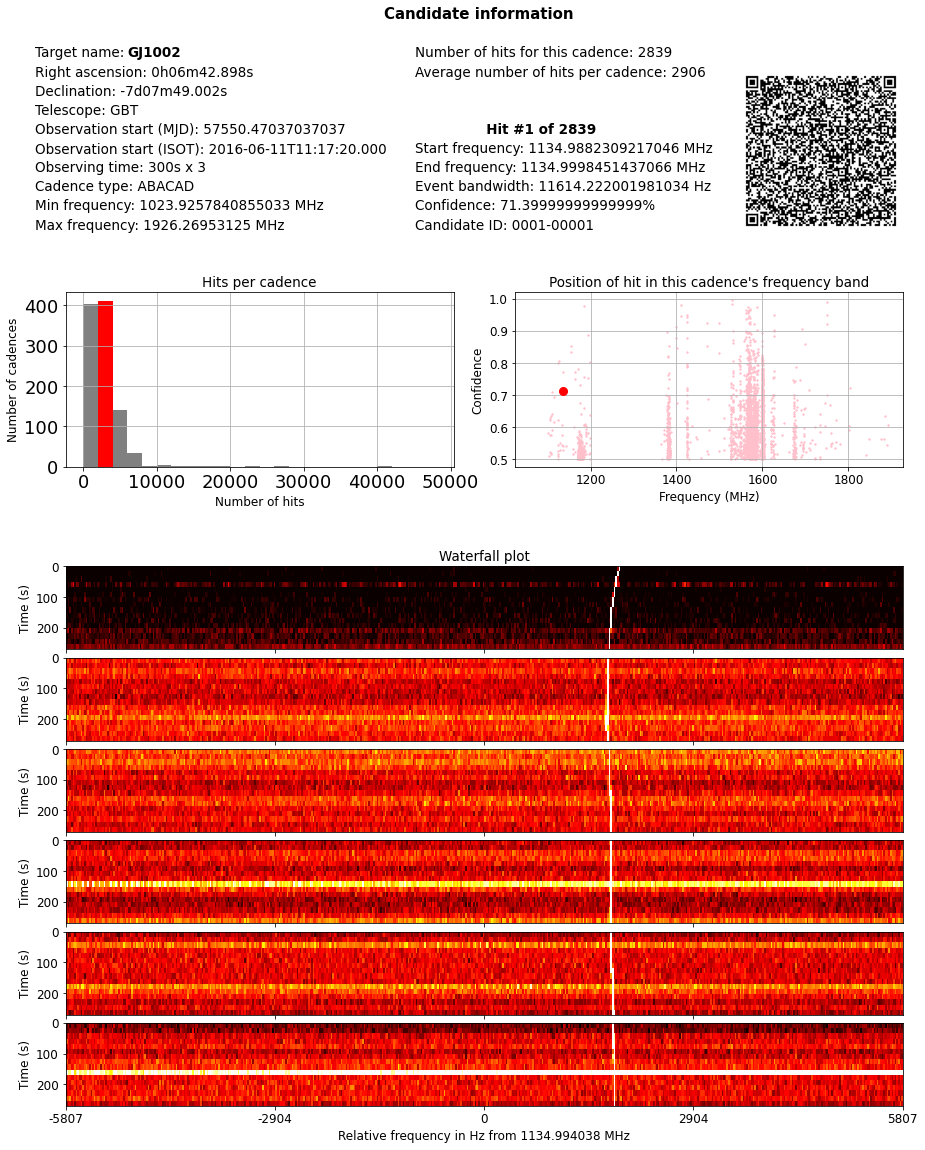

In [52]:
plot_from_ID(all_cadences, results, num_hits_list)

In [33]:
# # Using only a sample of cadences:

# sample_cadences = all_cadences[:3]

In [34]:
# # Saving png images for hits at or above a chosen confidence threshold

# t = 0.99

# for cadence_name in sample_cadences:
#     cadence = Cadence(cadence_name, results)

#     for j in range(cadence.num_hits):
#         if cadence.hits[j][2] >= t:
            
#             hit = Hit(cadence, j)
            
#             plot_everything(hit, sample_cadences, num_hits_list, output_dirname='visualizers_clean_test_3', 
#                             save=True)
#             plt.close()

In [35]:
# Looking at the data

In [36]:
#scatter_plot_all_hits_A(all_cadences, results)

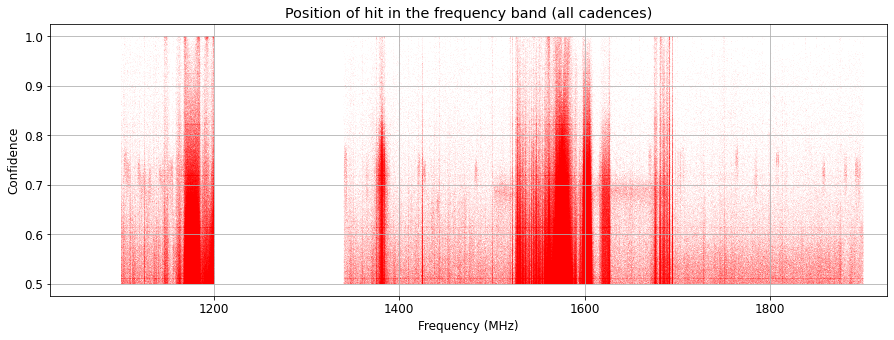

In [41]:
# plt.figure(figsize=(15, 5))
# scatter_plot_all_hits_B()
# plt.show()

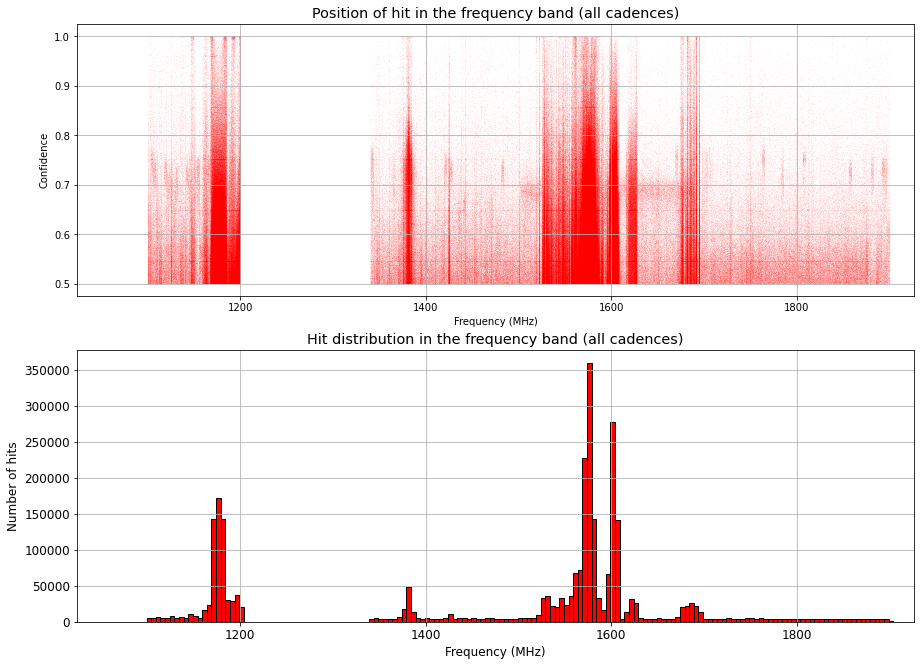

In [36]:
plt.figure(figsize=(15, 11))

plt.subplot(2, 1, 1)
scatter_plot_all_hits(all_cadences, results)

plt.subplot(2, 1, 2)
hist_all_hits(all_cadences, results)
   
plt.show()

In [37]:
# # Observing the number of hits per cadence:

# tab = ' ' * (14 - len('Cadence index'))
# print('Cadence index', tab, 'Number of hits')

# for i, num in enumerate(num_hits_list):
#     tab = ' ' * (14 - len(str(i)))
#     print(i, tab, num)

In [38]:
# Finding the maximum hits for one cadence:

print('Maximum number of hits for a single cadence:', max(num_hits_list))

Maximum number of hits for a single cadence: 41062


In [39]:
# Finding the total number of hits for across all cadences:

print('Total number of hits across all cadences:', np.sum(num_hits_list))

Total number of hits across all cadences: 2917789


In [40]:
# # Investigating the number of hits per cadence at or above a confidence threshold:

# THRESHOLD = 0.99

# tab = ' ' * (16 - len('Cadence index'))
# print('Cadence index', tab, 'Number of {}% hits'.format(THRESHOLD * 100))

# filtered_num_hits_list = []

# for i in range(len(all_cadences)):
    
#     cadence = Cadence(all_cadences[i], results)
    
#     k = 0
    
#     for j in range(cadence.num_hits):
#         if cadence.hits[j][2] >= THRESHOLD:
#             k += 1
            
#     filtered_num_hits_list.append(k)
    
#     tab = ' ' * (16 - len(str(i)))
#     print(i, tab, k)

In [41]:
# # Finding the maximum hits at or above the threshold for one cadence:

# print('Maximum number of {}% hits for a single cadence:'.format(THRESHOLD * 100), max(filtered_num_hits_list))

In [42]:
# # Finding the total number of hits for across all cadences:

# print('Total number of {}% hits across all cadences:'.format(THRESHOLD * 100), np.sum(filtered_num_hits_list))

In [28]:
# After manually removing the outlier at index 239 by creating a new results directory without it:
results_clean = results
# results_clean = '/home/lrizk/GBT_Candidates_Explorer/results_clean'

In [29]:
new_cadence_list = get_cadence_list(results_clean)
new_num_hits_list = get_num_hits_per_cadence(new_cadence_list, results_clean)

In [30]:
def get_num_hits_above_threshold(cadence_list: List[str], dirname: str, threshold: float) -> int:
    """Return the total number of hits across all cadences in cadence_list that have a confidence rate at or above
    threshold. Cadences must be initialized with the appropriate results directory dirname.
    """
    
    num = 0
    
    for i in range(len(cadence_list)):
        cadence = Cadence(cadence_list[i], dirname)
        
        for j in range(cadence.num_hits):                  
            if cadence.hits[j][2] >= threshold:
                num += 1
    
    return num

In [31]:
def get_filtered_num_hits_above_threshold(cadence_list: List[str], dirname: str, threshold: float,
                                         rfi_bins: List[List[float]]) -> int:
    """Return the total number of hits across all cadences in cadence_list that have a confidence rate at or above
    threshold and whose mid frequency does not fall in one of the intervals listed in rfi_bins. Cadences must be 
    initialized with the appropriate results directory dirname.
    """
    
    num = 0
    
    for i in range(len(cadence_list)):
        cadence = Cadence(cadence_list[i], dirname)
        
        for j in range(cadence.num_hits):      
            
            if cadence.hits[j][2] >= threshold:
                                
                mid_freq = (cadence.hits[j][0] + cadence.hits[j][1]) / 2
                
                if not is_in_rfi_bin(mid_freq, rfi_bins):
                    num += 1
    
    return num

In [32]:



#scatter_plot_all_hits_A(new_cadence_list, results_clean)

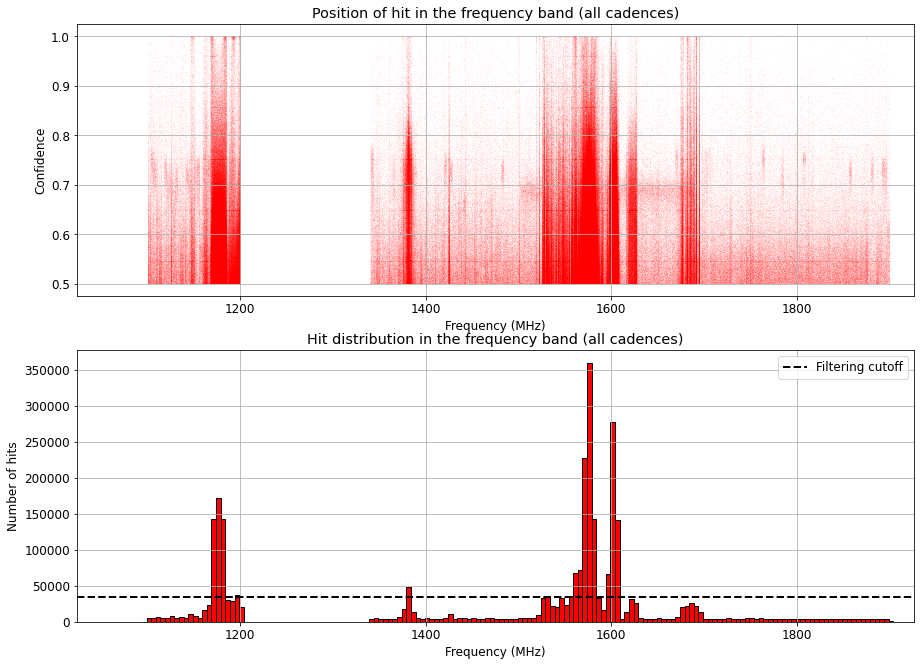

In [47]:
# plt.figure(figsize=(15, 11))
# plt.rc('font', size=12)

# plt.subplot(2, 1, 1)
# scatter_plot_all_hits(new_cadence_list, results_clean)

# plt.subplot(2, 1, 2)
# intervals, abundance = hist_all_hits(new_cadence_list, results_clean)
# plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Filtering cutoff')
# plt.legend()

# plt.show()

# rfi_intervals = get_rfi_bins(intervals, abundance)

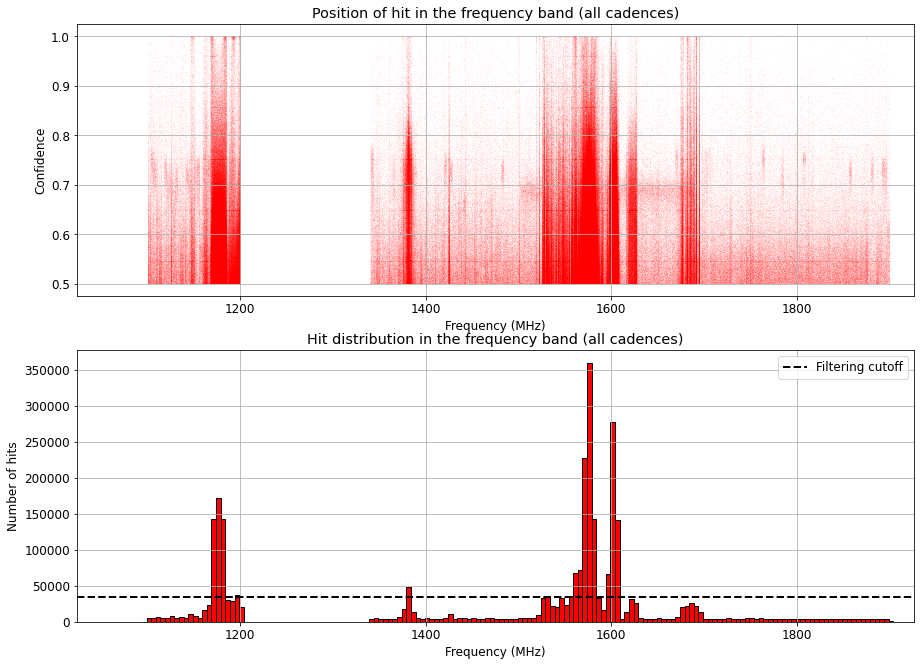

In [35]:
plt.figure(figsize=(15, 11))
plt.rc('font', size=12)

plt.subplot(2, 1, 1)
scatter_plot_all_hits_B()

plt.subplot(2, 1, 2)
intervals, abundance = hist_all_hits_B()
plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Filtering cutoff')
plt.legend()

plt.show()

rfi_intervals = get_rfi_bins(intervals, abundance)

In [36]:
# thresholds = np.arange(0.5, 1.05, 0.05)

# num_list = []
# for threshold in thresholds:
#     num = get_num_hits_above_threshold(new_cadence_list, results_clean, threshold)
#     num_list.append(num)

In [37]:
# filtered_num_list = []
# for threshold in thresholds:
#     num = get_filtered_num_hits_above_threshold(new_cadence_list, results_clean, threshold, rfi_intervals)
#     filtered_num_list.append(num)

In [44]:
thresholds = np.arange(0.5, 1.05, 0.05)

In [33]:




# f = open('temp_C.csv', 'w')

# for threshold in thresholds:
#     num1 = get_num_hits_above_threshold(new_cadence_list, results_clean, threshold)
#     num2 = get_filtered_num_hits_above_threshold(new_cadence_list, results_clean, threshold, rfi_intervals)
#     f.write(str(num1) + ',' + str(num2) + '\n')

# f.close()

In [34]:
num_list, filtered_num_list = np.loadtxt('temp_C.csv', delimiter=',', unpack=True)

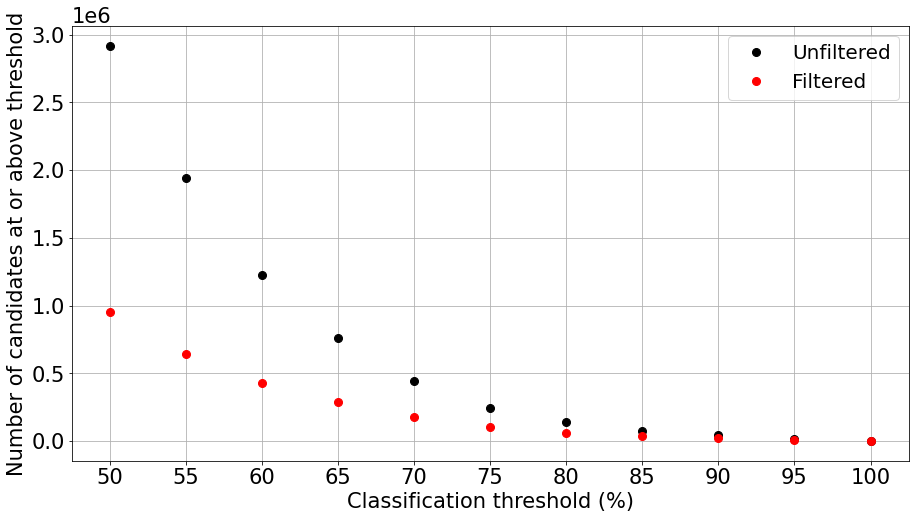

In [59]:
plt.figure(figsize=(15, 8))
plt.rc('font', size=21)

plt.plot(thresholds * 100, num_list, 'o', ms=8, color='black', label='Unfiltered')
plt.plot(thresholds * 100, filtered_num_list, 'o', ms=8, color='red', label='Filtered')

plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Classification threshold (%)')
plt.ylabel('Number of candidates at or above threshold')

plt.xticks(thresholds * 100)

#plt.savefig('Figure13.png', bbox_inches='tight')
plt.show()

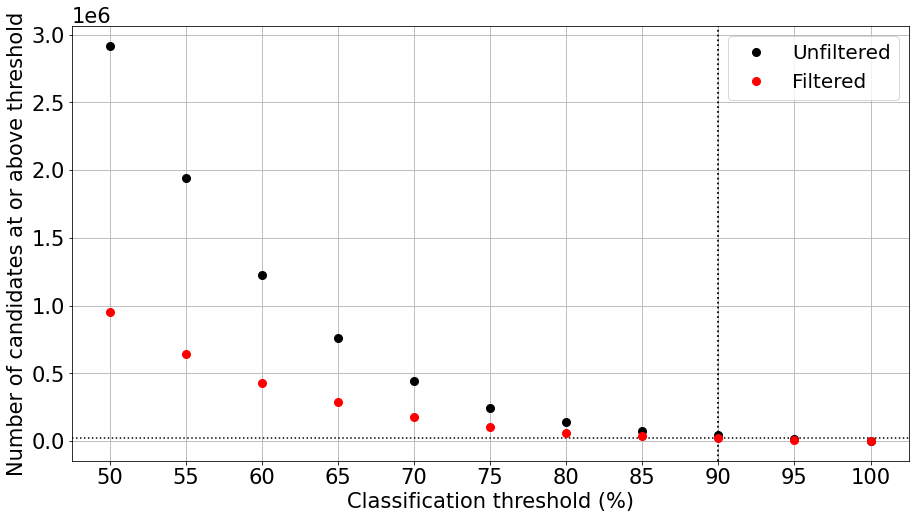

In [45]:
plt.figure(figsize=(15, 8))
plt.rc('font', size=21)

plt.axhline(y=filtered_num_list[-3], ls=':', lw=1.5, color='k')
plt.axvline(x=90, ls=':', lw=1.8, color='k')

plt.plot(thresholds * 100, num_list, 'o', ms=8, color='black', label='Unfiltered')
plt.plot(thresholds * 100, filtered_num_list, 'o', ms=8, color='red', label='Filtered')

plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Classification threshold (%)')
plt.ylabel('Number of candidates at or above threshold')

plt.xticks(thresholds * 100)

plt.savefig('Figure13.png', bbox_inches='tight')
plt.show()

In [42]:
num_list, filtered_num_list

(array([2917789., 1944261., 1227145.,  759447.,  445435.,  246346.,
         137852.,   77014.,   42016.,   18412.,       0.]),
 array([950984., 641257., 427239., 287572., 179642., 103465.,  61513.,
         35841.,  20515.,   9327.,      0.]))

In [41]:
num_list, filtered_num_list = \
(np.array([2917789., 1944261., 1227145.,  759447.,  445435.,  246346.,
         137852.,   77014.,   42016.,   18412.,       0.]),
 np.array([950984., 641257., 427239., 287572., 179642., 103465.,  61513.,
         35841.,  20515.,   9327.,      0.]))

In [39]:
num_list, filtered_num_list

(array([2917789., 1944261., 1227145.,  759447.,  445435.,  246346.,
         137852.,   77014.,   42016.,   18412.,       0.]),
 array([950984., 641257., 427239., 287572., 179642., 103465.,  61513.,
         35841.,  20515.,   9327.,      0.]))

In [89]:
filtered_num_list[-3]

20515.0

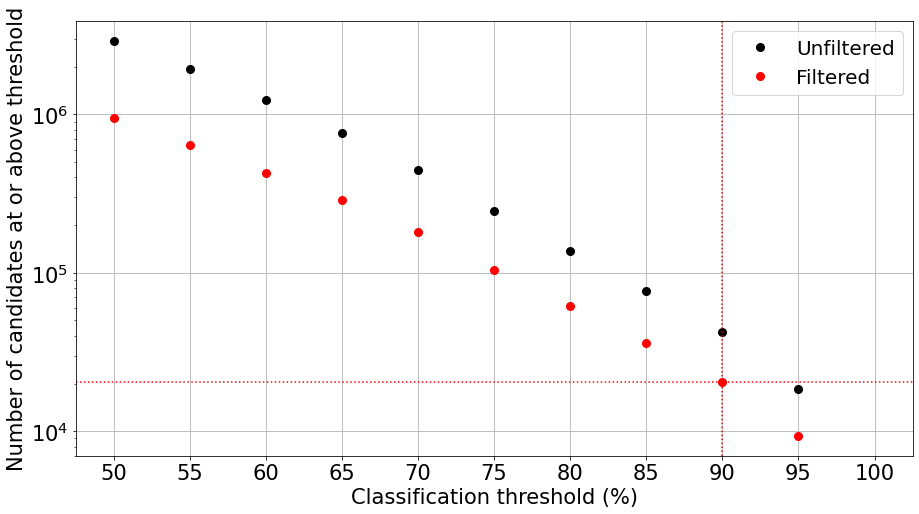

In [86]:
plt.figure(figsize=(15, 8))
plt.rc('font', size=21)

plt.plot(thresholds * 100, num_list, 'o', ms=8, color='black', label='Unfiltered')
plt.plot(thresholds * 100, filtered_num_list, 'o', ms=8, color='red', label='Filtered')

plt.axhline(y=filtered_num_list[-3], ls=':', lw=1.5, color='red')
plt.axvline(x=90, ls=':', lw=1.5, color='red')

plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Classification threshold (%)')
plt.ylabel('Number of candidates at or above threshold')

plt.xticks(thresholds * 100)

plt.yscale('log')

#plt.savefig('Figure13.png', bbox_inches='tight')
plt.show()

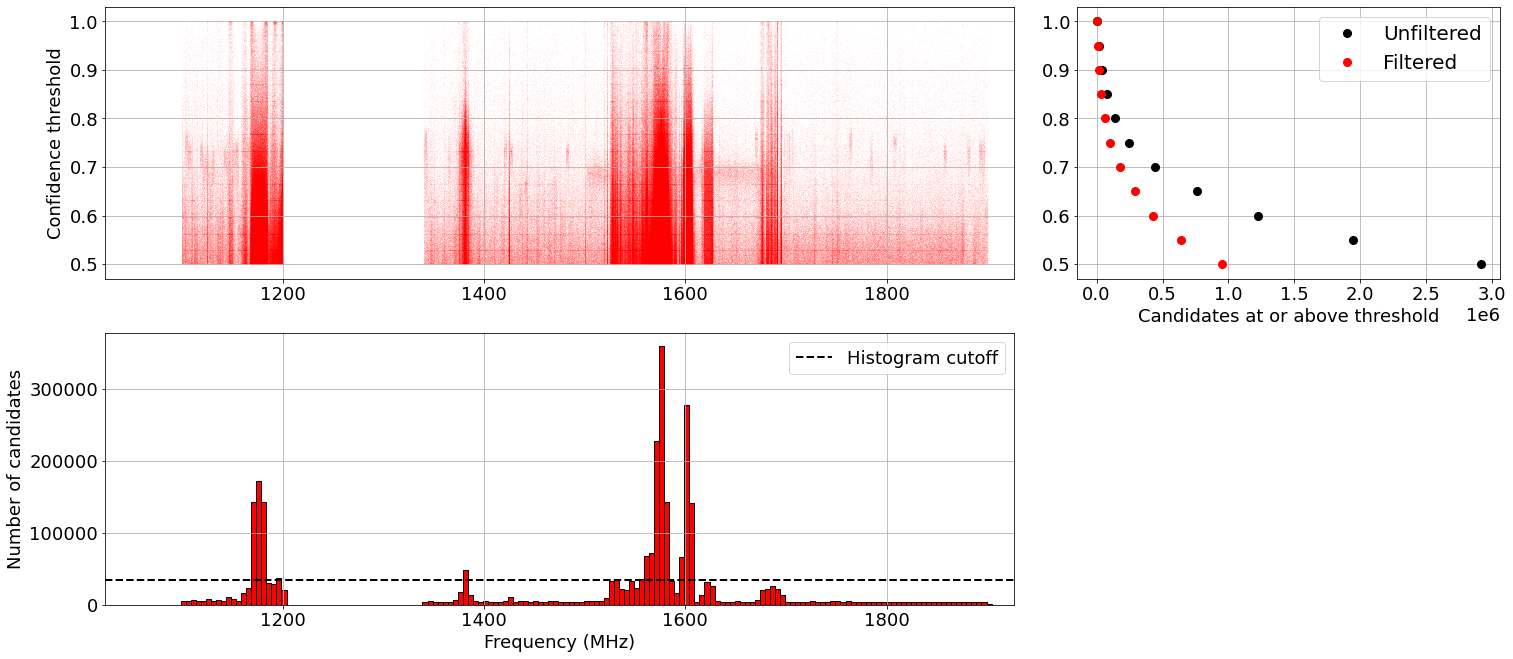

In [44]:
# grid2 = plt.GridSpec(2, 3, wspace=0.15, hspace=0.2)

# plt.figure(figsize=(25, 11))
# plt.rc('font', size=18)

# plt.subplot(grid2[:1, :2])
# scatter_plot_all_hits_B()

# plt.subplot(grid2[1:, :2])
# intervals, abundance = hist_all_hits_B()
# plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Histogram cutoff')
# plt.legend()

# plt.subplot(grid2[:1, 2:])
# plt.plot(num_list, thresholds * 100, 'o', ms=8, color='black', label='Unfiltered')
# plt.plot(filtered_num_list, thresholds * 100, 'o', ms=8, color='red', label='Filtered')

# plt.grid()
# plt.legend(fontsize=20)
# plt.xlabel('Candidates at or above threshold')

# plt.ylim(47, 103)
# plt.yticks(np.arange(50, 110, 10), labels=['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

# plt.savefig('Figure12.png', bbox_inches='tight')
# plt.show()

In [51]:
# Extra section: filtering results automatically

In [52]:
# Doing everything with one function but this time filtered

In [53]:
# generate_and_save_visualizers_and_movie(dirname='results_clean', threshold=0.99, 
#                                         output_dirname='visualizers_clean_test_4',
#                                         video_name='filtered_movie_clean_test', fps=4, filtering=True)

In [34]:
output = hist_all_hits(all_cadences, results)


*** Oops, hdf_reader: examine_h5: HDF5 Time-dimension data corruption ***

root            ERROR    Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/lrizk/.local/lib/python3.7/site-packages/blimpy/io/hdf_reader.py", line 40, in examine_h5
    xx = h5["data"][-1][0][0]
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/opt/conda/lib/python3.7/site-packages/h5py/_hl/dataset.py", line 573, in __getitem__
    self.id.read(mspace, fspace, arr, mtype, dxpl=self._dxpl)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-8166a4b80014>", line 1, in 

SystemExit: 86

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [38]:
output

(array([1023.92578265, 1028.92578265, 1033.92578265, 1038.92578265,
        1043.92578265, 1048.92578265, 1053.92578265, 1058.92578265,
        1063.92578265, 1068.92578265, 1073.92578265, 1078.92578265,
        1083.92578265, 1088.92578265, 1093.92578265, 1098.92578265,
        1103.92578265, 1108.92578265, 1113.92578265, 1118.92578265,
        1123.92578265, 1128.92578265, 1133.92578265, 1138.92578265,
        1143.92578265, 1148.92578265, 1153.92578265, 1158.92578265,
        1163.92578265, 1168.92578265, 1173.92578265, 1178.92578265,
        1183.92578265, 1188.92578265, 1193.92578265, 1198.92578265,
        1203.92578265, 1208.92578265, 1213.92578265, 1218.92578265,
        1223.92578265, 1228.92578265, 1233.92578265, 1238.92578265,
        1243.92578265, 1248.92578265, 1253.92578265, 1258.92578265,
        1263.92578265, 1268.92578265, 1273.92578265, 1278.92578265,
        1283.92578265, 1288.92578265, 1293.92578265, 1298.92578265,
        1303.92578265, 1308.92578265, 1313.92578

In [37]:
output = \
(np.array([1023.92578265, 1028.92578265, 1033.92578265, 1038.92578265,
        1043.92578265, 1048.92578265, 1053.92578265, 1058.92578265,
        1063.92578265, 1068.92578265, 1073.92578265, 1078.92578265,
        1083.92578265, 1088.92578265, 1093.92578265, 1098.92578265,
        1103.92578265, 1108.92578265, 1113.92578265, 1118.92578265,
        1123.92578265, 1128.92578265, 1133.92578265, 1138.92578265,
        1143.92578265, 1148.92578265, 1153.92578265, 1158.92578265,
        1163.92578265, 1168.92578265, 1173.92578265, 1178.92578265,
        1183.92578265, 1188.92578265, 1193.92578265, 1198.92578265,
        1203.92578265, 1208.92578265, 1213.92578265, 1218.92578265,
        1223.92578265, 1228.92578265, 1233.92578265, 1238.92578265,
        1243.92578265, 1248.92578265, 1253.92578265, 1258.92578265,
        1263.92578265, 1268.92578265, 1273.92578265, 1278.92578265,
        1283.92578265, 1288.92578265, 1293.92578265, 1298.92578265,
        1303.92578265, 1308.92578265, 1313.92578265, 1318.92578265,
        1323.92578265, 1328.92578265, 1333.92578265, 1338.92578265,
        1343.92578265, 1348.92578265, 1353.92578265, 1358.92578265,
        1363.92578265, 1368.92578265, 1373.92578265, 1378.92578265,
        1383.92578265, 1388.92578265, 1393.92578265, 1398.92578265,
        1403.92578265, 1408.92578265, 1413.92578265, 1418.92578265,
        1423.92578265, 1428.92578265, 1433.92578265, 1438.92578265,
        1443.92578265, 1448.92578265, 1453.92578265, 1458.92578265,
        1463.92578265, 1468.92578265, 1473.92578265, 1478.92578265,
        1483.92578265, 1488.92578265, 1493.92578265, 1498.92578265,
        1503.92578265, 1508.92578265, 1513.92578265, 1518.92578265,
        1523.92578265, 1528.92578265, 1533.92578265, 1538.92578265,
        1543.92578265, 1548.92578265, 1553.92578265, 1558.92578265,
        1563.92578265, 1568.92578265, 1573.92578265, 1578.92578265,
        1583.92578265, 1588.92578265, 1593.92578265, 1598.92578265,
        1603.92578265, 1608.92578265, 1613.92578265, 1618.92578265,
        1623.92578265, 1628.92578265, 1633.92578265, 1638.92578265,
        1643.92578265, 1648.92578265, 1653.92578265, 1658.92578265,
        1663.92578265, 1668.92578265, 1673.92578265, 1678.92578265,
        1683.92578265, 1688.92578265, 1693.92578265, 1698.92578265,
        1703.92578265, 1708.92578265, 1713.92578265, 1718.92578265,
        1723.92578265, 1728.92578265, 1733.92578265, 1738.92578265,
        1743.92578265, 1748.92578265, 1753.92578265, 1758.92578265,
        1763.92578265, 1768.92578265, 1773.92578265, 1778.92578265,
        1783.92578265, 1788.92578265, 1793.92578265, 1798.92578265,
        1803.92578265, 1808.92578265, 1813.92578265, 1818.92578265,
        1823.92578265, 1828.92578265, 1833.92578265, 1838.92578265,
        1843.92578265, 1848.92578265, 1853.92578265, 1858.92578265,
        1863.92578265, 1868.92578265, 1873.92578265, 1878.92578265,
        1883.92578265, 1888.92578265, 1893.92578265, 1898.92578265,
        1903.92578265, 1908.92578265, 1913.92578265, 1918.92578265,
        1923.92578265, 1928.92578265]),
 np.array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,   5918.,   5945.,   6230.,   4984.,   5339.,   7425.,
          5458.,   6444.,   5468.,  11341.,   7668.,   5275.,  16138.,
         22807., 142274., 172466., 142574.,  30005.,  29516.,  37865.,
         19850.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
          3822.,   4776.,   4108.,   3315.,   4350.,   4383.,   6424.,
         18222.,  48355.,  13070.,   4597.,   4265.,   4967.,   3621.,
          4362.,   4162.,   4821.,  10327.,   4071.,   5231.,   5859.,
          4110.,   4924.,   4338.,   4426.,   4718.,   4771.,   4525.,
          4407.,   4311.,   3829.,   3568.,   5405.,   4969.,   5059.,
          4740.,   9516.,  32952.,  35221.,  22593.,  20534.,  33017.,
         23319.,  35637.,  67210.,  71507., 227302., 359214., 142286.,
         32460.,  16977.,  66515., 277255., 141124.,   4511.,  13221.,
         31649.,  25692.,   4726.,   4324.,   4011.,   4545.,   4759.,
          3883.,   3929.,   4050.,   6397.,  20068.,  21946.,  25569.,
         21980.,  13007.,   4457.,   3664.,   3747.,   3551.,   3681.,
          4677.,   3395.,   3449.,   3871.,   4701.,   5502.,   4078.,
          4651.,   3935.,   3650.,   3502.,   3934.,   4145.,   3715.,
          3927.,   4081.,   4017.,   4460.,   3882.,   3253.,   3592.,
          3567.,   3618.,   3826.,   3693.,   4201.,   4374.,   4014.,
          3690.,   4071.,   4293.,   3265.,   3812.,   3953.,   4004.,
           787.,      0.,      0.,      0.,      0.,      0.]))

In [36]:
output

(array([1023.92578265, 1028.92578265, 1033.92578265, 1038.92578265,
        1043.92578265, 1048.92578265, 1053.92578265, 1058.92578265,
        1063.92578265, 1068.92578265, 1073.92578265, 1078.92578265,
        1083.92578265, 1088.92578265, 1093.92578265, 1098.92578265,
        1103.92578265, 1108.92578265, 1113.92578265, 1118.92578265,
        1123.92578265, 1128.92578265, 1133.92578265, 1138.92578265,
        1143.92578265, 1148.92578265, 1153.92578265, 1158.92578265,
        1163.92578265, 1168.92578265, 1173.92578265, 1178.92578265,
        1183.92578265, 1188.92578265, 1193.92578265, 1198.92578265,
        1203.92578265, 1208.92578265, 1213.92578265, 1218.92578265,
        1223.92578265, 1228.92578265, 1233.92578265, 1238.92578265,
        1243.92578265, 1248.92578265, 1253.92578265, 1258.92578265,
        1263.92578265, 1268.92578265, 1273.92578265, 1278.92578265,
        1283.92578265, 1288.92578265, 1293.92578265, 1298.92578265,
        1303.92578265, 1308.92578265, 1313.92578

In [39]:
cut_offs = np.linspace(output[1].max(),-0.1, 50)
accum = []
for i in range(cut_offs.shape[0]):
    threshval = cut_offs[i]
    count = 0
    for k in range(output[1].shape[0]):
        if output[1][k] > threshval:
            count +=1
    accum.append(count)

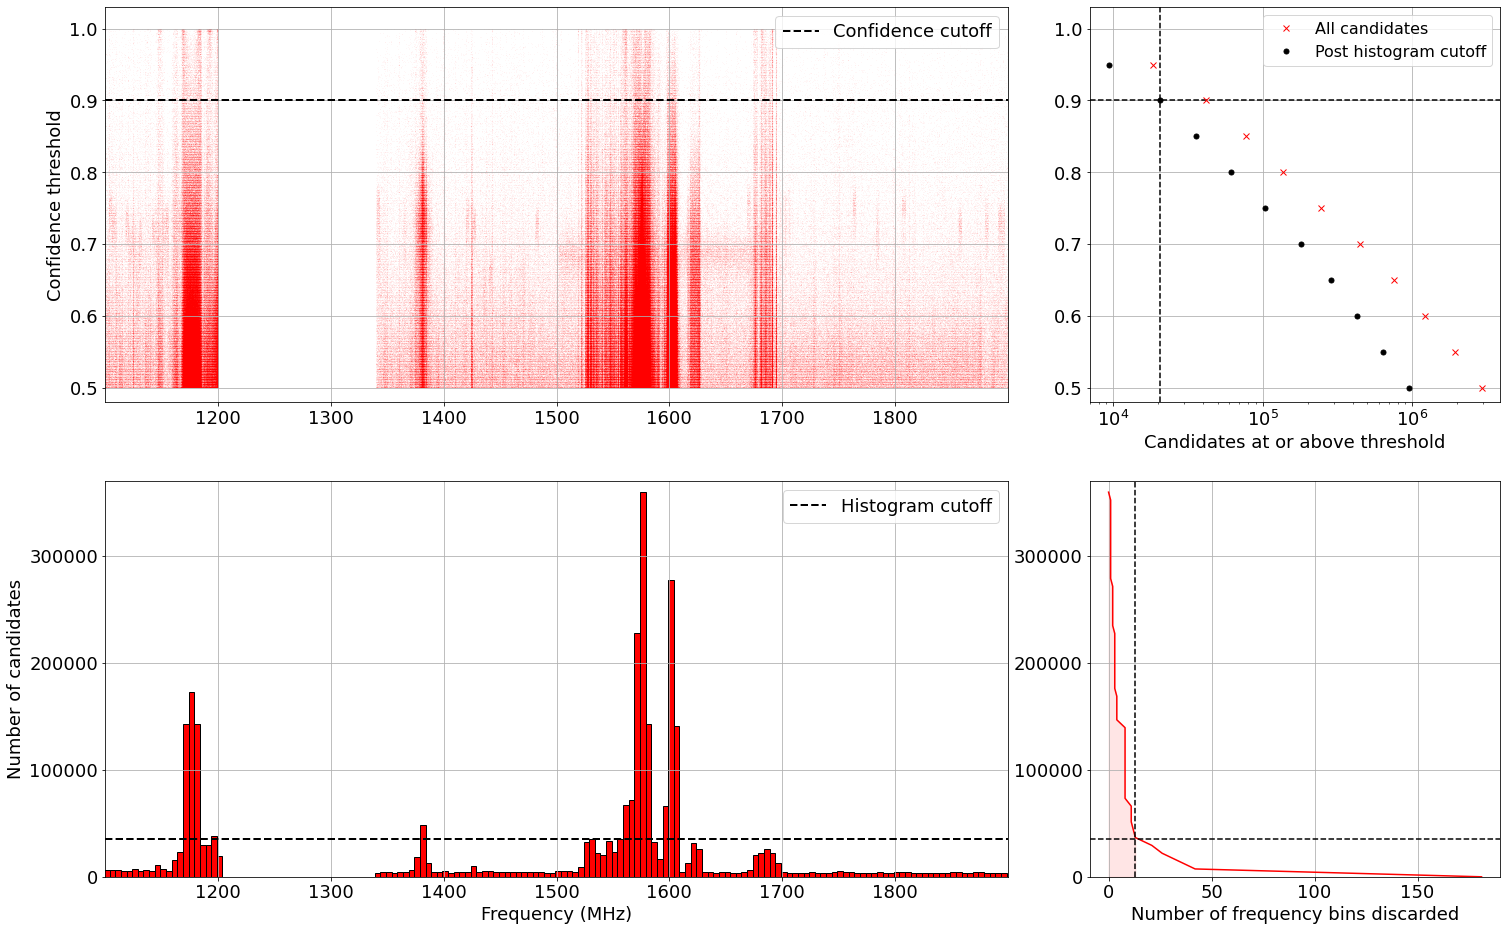

In [47]:
grid2 = plt.GridSpec(2, 3, wspace=0.2, hspace=0.2)

plt.figure(figsize=(25, 16))
plt.rc('font', size=18)


plt.subplot(grid2[:1, :2])
scatter_plot_all_hits_B()
plt.axhline(y=.9, ls='--', lw=2, color='black', label='Confidence cutoff')
plt.legend(loc='upper right')


plt.subplot(grid2[1:, :2])
intervals, abundance = hist_all_hits_B()
plt.ylim(0, cut_offs.max() + 10000)
plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Histogram cutoff')
plt.legend()


plt.subplot(grid2[:1, 2:])

plt.axvline(x=filtered_num_list[-3], ls='--', lw=1.5, color='black')
plt.axhline(y=90, ls='--', lw=1.5, color='black')

plt.plot(num_list, thresholds * 100, 'x', ms=6, color='red', label='All candidates')
plt.plot(filtered_num_list, thresholds * 100, 'o', ms=5, color='black', label='Post histogram cutoff')

plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Candidates at or above threshold')

plt.xscale('log')
plt.ylim(48, 103)
plt.yticks(np.arange(50, 110, 10), labels=['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])


plt.subplot(grid2[1:, 2:])

plt.plot(accum, cut_offs, c='red')
plt.axvline(x=13, ls='--', color='black')
plt.axhline(y=35000, ls='--', color='black')
plt.fill_between(accum[:45], cut_offs[:45], alpha = 0.1, color='red')

plt.ylim(0, cut_offs.max() + 10000)
plt.yticks(np.arange(0, 3e5 + 1, 1e5))

plt.xlabel('Number of frequency bins discarded')
plt.grid()


plt.savefig('Figure12.pdf', format='pdf', bbox_inches='tight')
plt.show()

matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially tr

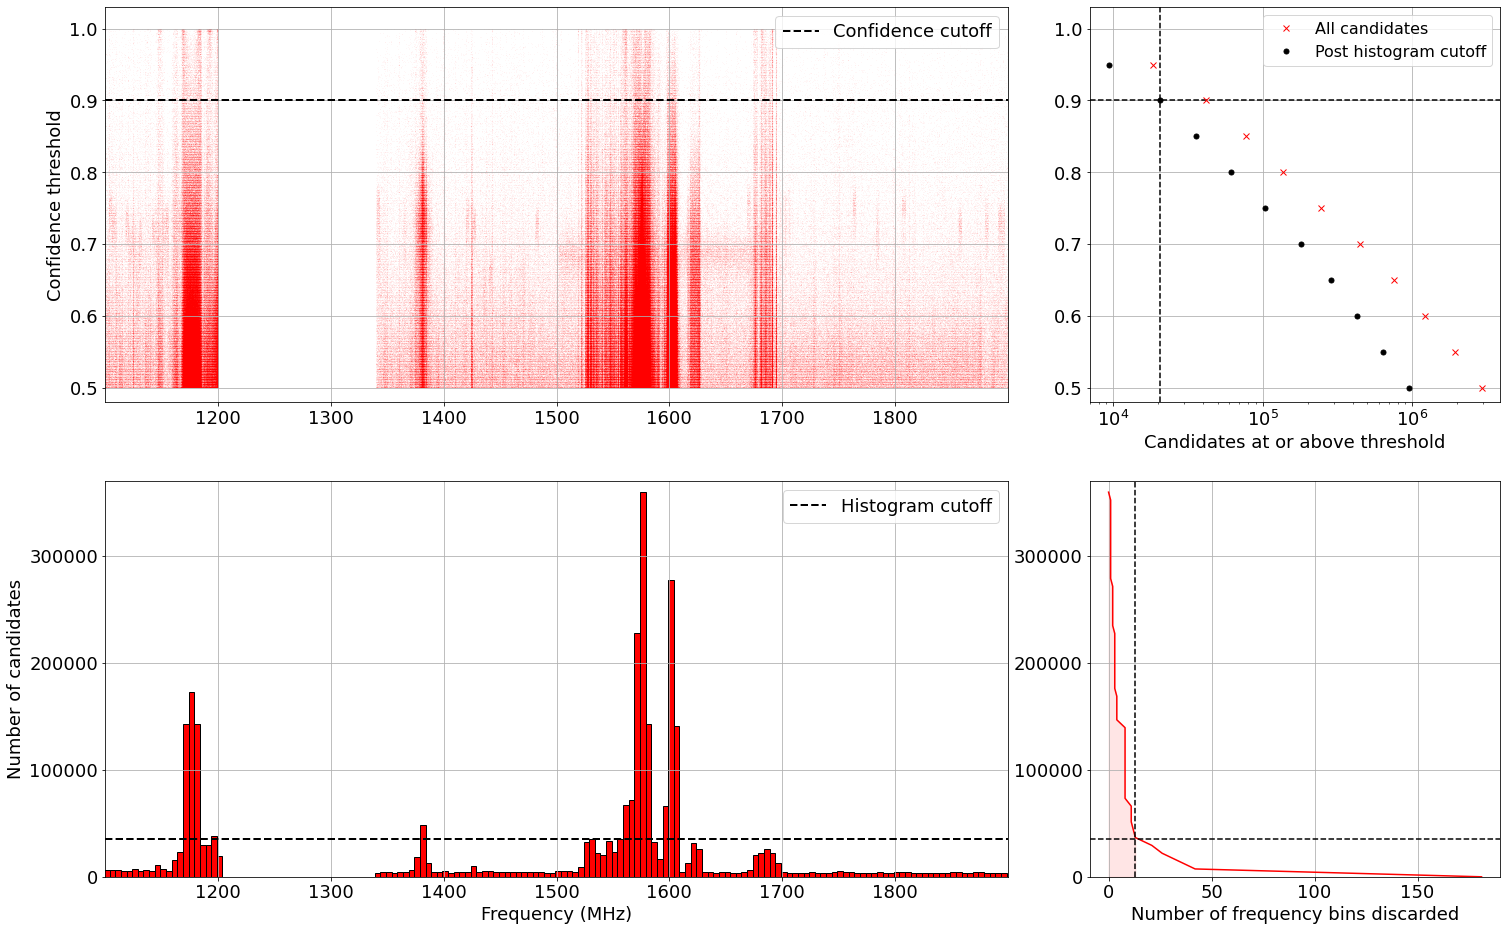

In [49]:
grid2 = plt.GridSpec(2, 3, wspace=0.2, hspace=0.2)

plt.figure(figsize=(25, 16))
plt.rc('font', size=18)


plt.subplot(grid2[:1, :2])
scatter_plot_all_hits_B()
plt.axhline(y=.9, ls='--', lw=2, color='black', label='Confidence cutoff')
plt.legend(loc='upper right')


plt.subplot(grid2[1:, :2])
intervals, abundance = hist_all_hits_B()
plt.ylim(0, cut_offs.max() + 10000)
plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Histogram cutoff')
plt.legend()


plt.subplot(grid2[:1, 2:])

plt.axvline(x=filtered_num_list[-3], ls='--', lw=1.5, color='black')
plt.axhline(y=90, ls='--', lw=1.5, color='black')

plt.plot(num_list, thresholds * 100, 'x', ms=6, color='red', label='All candidates')
plt.plot(filtered_num_list, thresholds * 100, 'o', ms=5, color='black', label='Post histogram cutoff')

plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Candidates at or above threshold')

plt.xscale('log')
plt.ylim(48, 103)
plt.yticks(np.arange(50, 110, 10), labels=['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])


plt.subplot(grid2[1:, 2:])

plt.plot(accum, cut_offs, c='red')
plt.axvline(x=13, ls='--', color='black')
plt.axhline(y=35000, ls='--', color='black')
plt.fill_between(accum[:45], cut_offs[:45], alpha = 0.1, color='red')

plt.ylim(0, cut_offs.max() + 10000)
plt.yticks(np.arange(0, 3e5 + 1, 1e5))

plt.xlabel('Number of frequency bins discarded')
plt.grid()


plt.savefig('Figure12.eps', format='eps', bbox_inches='tight')
plt.show()

1100.0003800727427 1899.9996185302734


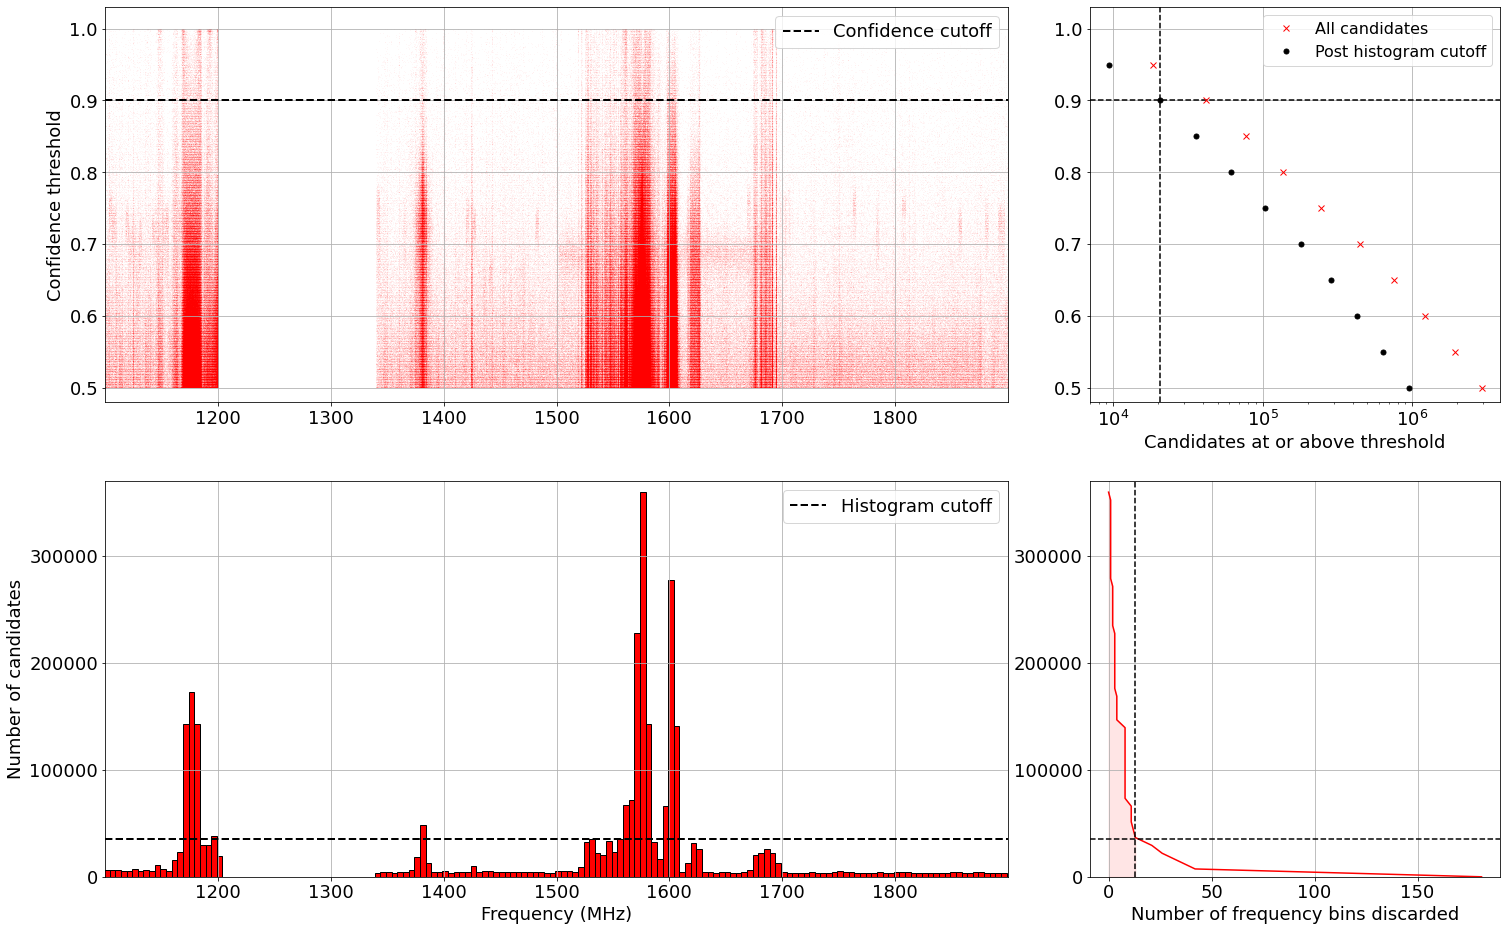

In [49]:
grid2 = plt.GridSpec(2, 3, wspace=0.2, hspace=0.2)

plt.figure(figsize=(25, 16))
plt.rc('font', size=18)


plt.subplot(grid2[:1, :2])
scatter_plot_all_hits_B()
plt.axhline(y=.9, ls='--', lw=2, color='black', label='Confidence cutoff')
plt.legend(loc='upper right')


plt.subplot(grid2[1:, :2])
intervals, abundance = hist_all_hits_B()
plt.ylim(0, cut_offs.max() + 10000)
plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Histogram cutoff')
plt.legend()


plt.subplot(grid2[:1, 2:])

plt.axvline(x=filtered_num_list[-3], ls='--', lw=1.5, color='black')
plt.axhline(y=90, ls='--', lw=1.5, color='black')

plt.plot(num_list, thresholds * 100, 'x', ms=6, color='red', label='All candidates')
plt.plot(filtered_num_list, thresholds * 100, 'o', ms=5, color='black', label='Post histogram cutoff')

plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Candidates at or above threshold')

plt.xscale('log')
plt.ylim(48, 103)
plt.yticks(np.arange(50, 110, 10), labels=['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])


plt.subplot(grid2[1:, 2:])

plt.plot(accum, cut_offs, c='red')
plt.axvline(x=13, ls='--', color='black')
plt.axhline(y=35000, ls='--', color='black')
plt.fill_between(accum[:45], cut_offs[:45], alpha = 0.1, color='red')

plt.ylim(0, cut_offs.max() + 10000)
plt.yticks(np.arange(0, 3e5 + 1, 1e5))

plt.xlabel('Number of frequency bins discarded')
plt.grid()


plt.savefig('Figure12.png', bbox_inches='tight')
plt.show()

In [ ]:
# grid2 = plt.GridSpec(2, 3, wspace=0.2, hspace=0.2)

# plt.figure(figsize=(25, 11))
# plt.rc('font', size=18)


# plt.subplot(grid2[:1, :2])
# scatter_plot_all_hits_B()


# plt.subplot(grid2[1:, :2])
# intervals, abundance = hist_all_hits_B()
# plt.axhline(y=RFI_FILTER, ls='--', lw=2, color='black', label='Histogram cutoff')
# plt.legend()


# plt.subplot(grid2[:1, 2:])

# plt.axhline(y=filtered_num_list[-3], ls='--', lw=1.5, color='black')
# plt.axvline(x=90, ls='--', lw=1.5, color='black')

# plt.plot(num_list, thresholds * 100, 'o', ms=5, color='black', label='All candidates')
# plt.plot(filtered_num_list, thresholds * 100, 'x', ms=5, color='blue', label='Post histogram cutoff')

# plt.grid()
# plt.legend(fontsize=20)
# plt.xlabel('Candidates at or above threshold')

# plt.ylim(47, 103)
# plt.yticks(np.arange(50, 110, 10), labels=['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])


# plt.subplot(grid2[1:, 2:])

# plt.plot(accum, cut_offs, c='red')
# plt.axvline(x=13, ls='--', color='black')
# plt.axhline(y=35000, ls='--', color='black')
# plt.fill_between(accum[:45], cut_offs[:45], alpha = 0.1, color='red')

# plt.ylim(0, cut_offs.max())
# plt.yticks(np.arange(0, 3e5 + 1, 1e5))

# plt.xlabel('Number of frequency bins discarded')
# plt.grid()


# #plt.savefig('Figure12.png', bbox_inches='tight')
# plt.show()